In [41]:
!pip install qiskit
!pip install qiskit-aer

In [42]:
!pip install pylatexenc

In [43]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt
import random

In [44]:
def generate_random_bit():
    return np.random.randint(2)

def generate_random_basis():
    return np.random.choice(['X', 'Z'])

def prepare_qubit(bit, basis):
    qc = QuantumCircuit(1, 1)
    if bit == 1:
        qc.x(0)
    if basis == 'X':
        qc.h(0)
    return qc

def measure_qubit(qc, basis):
    if basis == 'X':
        qc.h(0)
    qc.measure(0, 0)
    return qc

def alice_preparation(n):
    bits = [generate_random_bit() for _ in range(n)]
    bases = [generate_random_basis() for _ in range(n)]
    qubits = []

    for bit, basis in zip(bits, bases):
        qc = prepare_qubit(bit, basis)
        qubits.append((qc, basis))

    return bits, bases, qubits

# Number of qubits
n = 10  # Using 10 for brevity

alice_bits, alice_bases, qubits = alice_preparation(n)
print("Alice's bits:", alice_bits)
print("Alice's bases:", alice_bases)

Alice's bits: [0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Alice's bases: ['X', 'X', 'Z', 'Z', 'X', 'X', 'Z', 'X', 'Z', 'Z']


In [45]:
def bob_measurement(qubits):
    bases = [generate_random_basis() for _ in range(len(qubits))]
    results = []

    for (qc, _), basis in zip(qubits, bases):
        qc = measure_qubit(qc, basis)
        simulator = Aer.get_backend('aer_simulator')
        compiled_circuit = transpile(qc, simulator)
        result = simulator.run(compiled_circuit, shots=1).result()
        counts = result.get_counts()
        bit = int(list(counts.keys())[0])
        results.append(bit)

    return bases, results

bob_bases, bob_results = bob_measurement(qubits)
print("Bob's bases:", bob_bases)
print("Bob's results:", bob_results)

Bob's bases: ['X', 'X', 'Z', 'Z', 'Z', 'Z', 'Z', 'X', 'X', 'X']
Bob's results: [0, 1, 1, 1, 0, 0, 1, 0, 0, 1]


In [46]:
def eve_interception(qubits):
    eve_bases = [generate_random_basis() for _ in range(len(qubits))]
    intercepted_qubits = []

    for (qc, a_basis), e_basis in zip(qubits, eve_bases):
        qc = measure_qubit(qc, e_basis)
        simulator = Aer.get_backend('aer_simulator')
        compiled_circuit = transpile(qc, simulator)
        result = simulator.run(compiled_circuit, shots=1).result()
        counts = result.get_counts()
        bit = int(list(counts.keys())[0])
        intercepted_qubits.append((bit, e_basis))

        # Eve re-prepares the qubit
        qc = prepare_qubit(bit, e_basis)
        intercepted_qubits.append((qc, a_basis))

    return intercepted_qubits, eve_bases

intercepted_qubits, eve_bases = eve_interception(qubits)
print("Eve's bases:", eve_bases)

Eve's bases: ['X', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'X']


In [47]:
def extract_key(alice_bits, alice_bases, bob_bases, bob_results):
    key = []
    for a_bit, a_basis, b_basis, b_result in zip(alice_bits, alice_bases, bob_bases, bob_results):
        if a_basis == b_basis:
            key.append(a_bit)

    return key

def calculate_qber(alice_key, bob_key):
    errors = sum(1 for a, b in zip(alice_key, bob_key) if a != b)
    return errors / len(alice_key)

alice_key = extract_key(alice_bits, alice_bases, bob_bases, bob_results)
bob_key = extract_key(bob_results, bob_bases, bob_bases, bob_results)
qber = calculate_qber(alice_key, bob_key)

print("Alice's key:", alice_key)
print("Bob's key:", bob_key)
print(f"Quantum Bit Error Rate (QBER): {qber:.2%}")

Alice's key: [0, 1, 1, 1, 1, 0]
Bob's key: [0, 1, 1, 1, 0, 0, 1, 0, 0, 1]
Quantum Bit Error Rate (QBER): 16.67%


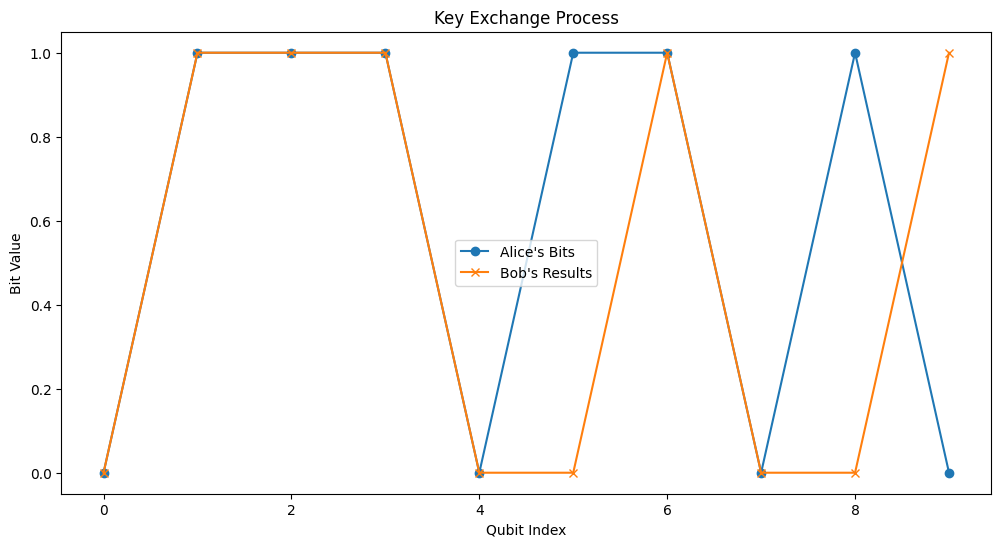

In [48]:
def visualize_key_exchange(alice_bits, alice_bases, bob_bases, bob_results):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(alice_bits, label='Alice\'s Bits', marker='o')
    ax.plot(bob_results, label='Bob\'s Results', marker='x')
    ax.set_xlabel('Qubit Index')
    ax.set_ylabel('Bit Value')
    ax.legend()
    ax.set_title('Key Exchange Process')
    plt.show()

visualize_key_exchange(alice_bits, alice_bases, bob_bases, bob_results)